In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io
import copy
import gc
from sklearn.svm import LinearSVC
from joblib import dump

In [5]:
B_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CelebA_Dataset(Dataset):
    def __init__(self, data_dir, split, transform):
        super().__init__()
        self.img_dir = os.path.join(data_dir + "/img_align_celeba")
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.make_split()
    
    def make_split(self):
        partition_list_path = os.path.join(self.data_dir, "list_eval_partition.txt")
        partition_list = np.loadtxt(partition_list_path, dtype=str)
        if self.split == "train":
            self.img_names = partition_list[partition_list[:, 1].astype(float) == 0, 0]
        elif self.split == "test":
            self.img_names = partition_list[partition_list[:, 1].astype(float) > 0, 0]
            
    def t(self, img):
        return self.transform(img)
        
    def __len__(self):
        return len(self.img_names)
    
    def t(self, img):
        return self.transform(img)
        
    def __getitem__(self, idx):
        file_name = os.path.join(self.img_dir, self.img_names[idx])
        img = np.array(Image.open(file_name))
        
        if self.transform:
            img = self.t(img)
    
        return img

In [64]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Resize((128, 128)),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((128, 128)),
#                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

In [65]:
train_dataset = CelebA_Dataset("./data", "train", t)
test_dataset = CelebA_Dataset("./data", "test", test_transform)

In [66]:
def visual(img_to_display=4):
    print("Displaying images in the dataset")
    fig, ax = plt.subplots(1, img_to_display)
    fig.set_size_inches(25, 8)
    
    for id in range(img_to_display):
        ax[id].imshow(test_dataset[id].permute(1,2,0))
        ax[id].axis("off")
    plt.tight_layout()
    plt.show()

Displaying images in the dataset


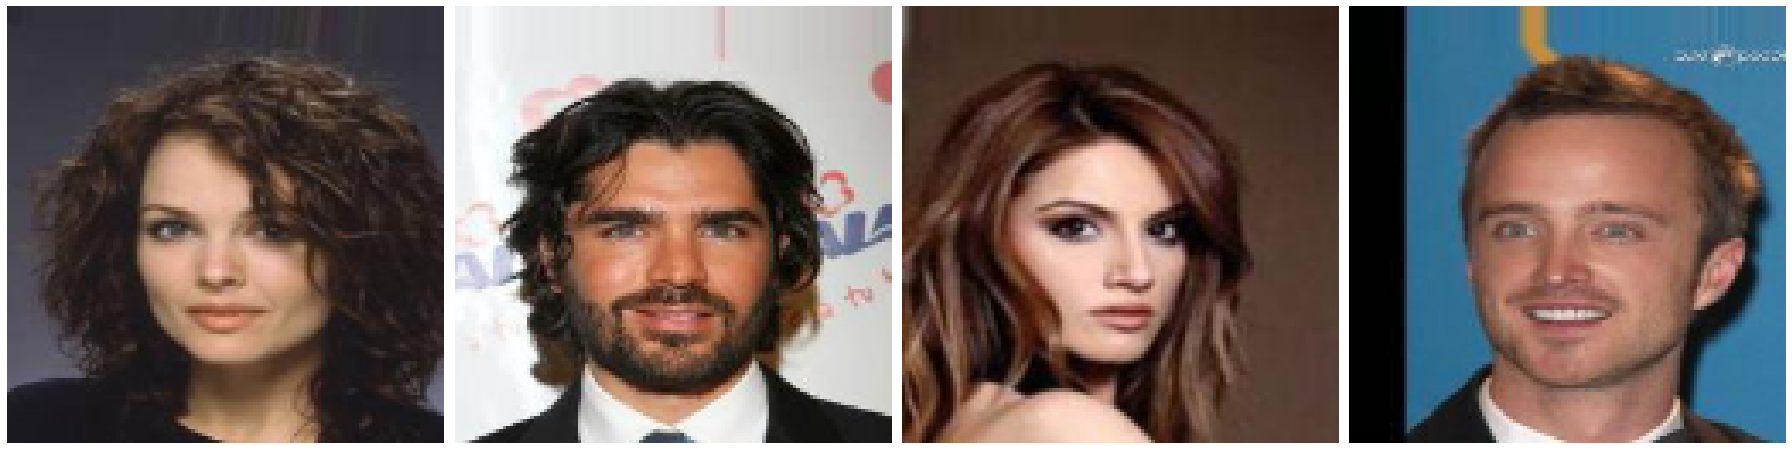

In [67]:
visual()

In [13]:
train_loader = DataLoader(train_dataset, batch_size=B_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=B_SIZE, shuffle=True)

In [42]:
class ConvVAE(nn.Module):
    def __init__(self, hidden_dim = [128,16,16], latent_dim = 256):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        
        self.fc_mu = nn.Linear(np.prod(hidden_dim), latent_dim)
        self.fc_var = nn.Linear(np.prod(hidden_dim), latent_dim)
    
        self.decoder_input = nn.Linear(latent_dim, np.prod(hidden_dim))
    
    def _make_encoder(self):
        layers = []
        layers.extend([nn.Conv2d(3, 64, 7, stride=2, padding=3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(3, stride=2, padding=1)])
        layers.extend([nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.BatchNorm2d(64)])
        layers.extend([nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.BatchNorm2d(128), nn.MaxPool2d(2, stride=2)])

        return nn.Sequential(*layers)
    
    def _make_decoder(self):
        layers = []
        layers.extend([nn.Upsample(scale_factor=2, mode='nearest')])
        layers.extend([nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU()])
        layers.extend([nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)])
        layers.extend([nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1), nn.BatchNorm2d(32), nn.ReLU()])
        layers.extend([nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()])
       
        return nn.Sequential(*layers)
    
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def encode(self, x):
        out = self.encoder(x)
        out = torch.flatten(out, start_dim=1)
        
        mu = self.fc_mu(out)
        log_var = self.fc_var(out)
        return mu, log_var
    
    def decode(self, z):
        out = self.decoder_input(z)
        out = out.view(-1, *(self.hidden_dim))
        out = self.decoder(out)
        return out
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var

In [27]:
def train(model, train_loader, optimizer, epoch):
    """
    Training for one epoch
    """
    loss_list = []
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    
    for idx, images in pbar:
       
        # put on gpu
        images = images.to(device)
        model = model.to(device)
        
        optimizer.zero_grad()
        
        img_recon, mu, logVar = model(images)
        
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())

        loss = F.binary_cross_entropy(img_recon, images, size_average=True) + kl_divergence
        print(loss)
        break
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        running_loss =+ loss.item()
        
        if idx % 1 == 0:
            pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")

    avg_loss = np.mean(loss_list)

    return loss_list, avg_loss

@torch.no_grad()
def testing(model, test_loader):
    """
    Testing the accuracy for validation set
    """
    model.eval()
    correct = 0
    loss_list = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))

    for idx, images in pbar:
        images = images.to(device)
        model = model.to(device)
        
        img_recon, mu, logVar = model(images)
        
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())

        loss = F.binary_cross_entropy(img_recon, images, size_average=True) + kl_divergence
        
        loss_list.append(loss.item())

    return np.mean(loss_list)
        
def training_model(model, optimizer, scheduler, train_loader, valid_loader, num_epochs):
    """
    Training and testing of model for N number of EPOCHS
    """
    stats = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "loss_iters":[]
    }
    for epoch in range(num_epochs):
        # testing 
        v_loss = testing(model, valid_loader)
        stats["val_loss"].append(v_loss)
        
        # training epoch
        stats['epoch'].append(epoch+1)
        
        epoch_loss_list, epoch_loss = train(model, train_loader, optimizer, epoch)
        scheduler.step()
        
        stats["train_loss"].append(epoch_loss)
        stats["loss_iters"] = stats["loss_iters"] + epoch_loss_list
            

        if epoch == 0 or (epoch+1) % 3 == 0 or (epoch+1) == num_epochs:
            saving_model(model, optimizer, epoch, stats)
            print(f"Loss for epoch: {epoch+1} is: ", stats["val_loss"][-1])

    print(f"Training completed")

In [28]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def saving_model(model, optimizer, epoch, stats):
    if not os.path.exists("models"):
        os.makedirs("models")
    save_path = f"models/ConvVAE_{epoch+1}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, save_path)
    

def loading_model(model, path):
    optimizer = torch.optim.Adam(params=model.parameters(), lr= 3e-4)
    checkpoint =  torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    stats = checkpoint['stats']
    return model, optimizer, epoch, stats

In [29]:
def training_full_model(model, train_loader, valid_loader, num_epochs):
    LR = 3e-4
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    training_model(model, optimizer, scheduler, train_loader, valid_loader, num_epochs)


In [40]:
convVae = ConvVAE()
training_full_model(convVae, train_loader, test_loader, 30)

In [61]:
def img_regeneration(model):
    with torch.no_grad():
        num_preds = 16
        p = torch.distributions.Normal(torch.zeros_like(0), torch.ones_like(std))
        z = p.rsample((num_preds,))
#         test_z = np.random.normal(size=(1, 256))
        out = conv_model.decode(torch.Tensor(z[0]))
        out = out[0].permute(1,2,0)
    return out

In [62]:
conv_model, optimizer, epoch, stats = loading_model(convVae, "models/ConvVAE_30.pth")

In [63]:
out = img_regeneration(conv_model)

NameError: name 'mu' is not defined

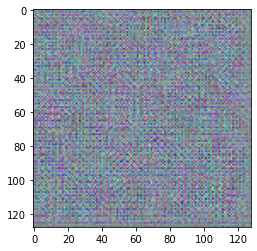

In [60]:
plt.imshow(out)